In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, r2_score
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported!")

✅ All libraries imported!


In [17]:
members_df = pd.read_csv('../data/gym_members_clean.csv')
exercise_df = pd.read_csv('../data/exercise_clean.csv')

print(f"✅ Members: {members_df.shape[0]} rows")
print(f"✅ Exercises: {exercise_df.shape[0]} rows")

✅ Members: 973 rows
✅ Exercises: 2918 rows


In [18]:
le_gender = LabelEncoder()
members_df['Gender_encoded'] = le_gender.fit_transform(members_df['Gender'])

print("Gender encoding:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))
print("✅ Done!")

Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}
✅ Done!


# 🤖 Model 1 — Calorie Predictor

In [19]:
calorie_features = [
    'Age',
    'Gender_encoded',
    'Weight (kg)',
    'Height (m)',
    'BMI',
    'Experience_Level',
    'Workout_Frequency (days/week)',
    'Session_Duration (hours)'
]

X_cal = members_df[calorie_features]
y_cal = members_df['Calories_Burned']

print(f"✅ Features ready!")
print(f"Average calories burned: {y_cal.mean():.0f}")
print(f"Min: {y_cal.min():.0f} | Max: {y_cal.max():.0f}")

✅ Features ready!
Average calories burned: 905
Min: 303 | Max: 1783


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X_cal, y_cal, test_size=0.2, random_state=42
)

calorie_model = RandomForestRegressor(n_estimators=100, random_state=42)
calorie_model.fit(X_train, y_train)

print("✅ Calorie model trained!")

✅ Calorie model trained!


In [21]:
y_pred_cal = calorie_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_cal)
r2 = r2_score(y_test, y_pred_cal)

print(f"✅ Mean Absolute Error: {mae:.2f} calories")
print(f"✅ R² Score: {r2:.4f}")

✅ Mean Absolute Error: 85.67 calories
✅ R² Score: 0.8596


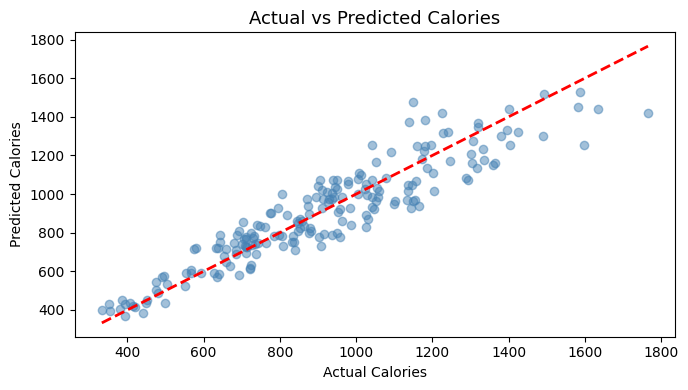

In [22]:
plt.figure(figsize=(7, 4))
plt.scatter(y_test, y_pred_cal, alpha=0.5, color='steelblue')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted Calories', fontsize=13)
plt.xlabel('Actual Calories')
plt.ylabel('Predicted Calories')
plt.tight_layout()
plt.show()

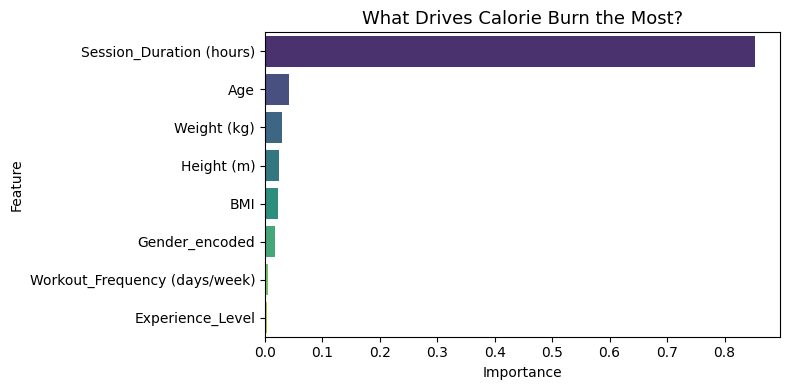

In [ ]:
#  Feature Importance for Calories
importance_cal = pd.DataFrame({
    'Feature': calorie_features,
    'Importance': calorie_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_cal, palette='viridis')
plt.title('What Drives Calorie Burn the Most?', fontsize=13)
plt.tight_layout()
plt.show()

# 🤖 Model 2 — Exercise Difficulty Classifier

In [24]:
# Encode categorical columns
le_bodypart = LabelEncoder()
le_equipment = LabelEncoder()
le_level = LabelEncoder()

exercise_df['BodyPart_encoded'] = le_bodypart.fit_transform(exercise_df['BodyPart'])
exercise_df['Equipment_encoded'] = le_equipment.fit_transform(exercise_df['Equipment'])
exercise_df['Level_encoded'] = le_level.fit_transform(exercise_df['Level'])

print("Level encoding:", dict(zip(le_level.classes_,
      le_level.transform(le_level.classes_))))
print("✅ Done!")

Level encoding: {'Beginner': np.int64(0), 'Expert': np.int64(1), 'Intermediate': np.int64(2)}
✅ Done!


In [ ]:
# STEP - 10
X_diff = exercise_df[['BodyPart_encoded', 'Equipment_encoded']]
y_diff = exercise_df['Level_encoded']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_diff, y_diff, test_size=0.2, random_state=42
)

difficulty_model = RandomForestClassifier(n_estimators=100, random_state=42)
difficulty_model.fit(X_train2, y_train2)

print("✅ Difficulty model trained!")

✅ Difficulty model trained!


In [26]:
y_pred_diff = difficulty_model.predict(X_test2)
accuracy = accuracy_score(y_test2, y_pred_diff)

print(f"✅ Difficulty Model Accuracy: {accuracy * 100:.2f}%")
print("\nDetailed Report:")
print(classification_report(y_test2, y_pred_diff,
      target_names=le_level.classes_))

✅ Difficulty Model Accuracy: 83.05%

Detailed Report:
              precision    recall  f1-score   support

    Beginner       0.48      0.14      0.21        95
      Expert       0.00      0.00      0.00         3
Intermediate       0.85      0.97      0.91       486

    accuracy                           0.83       584
   macro avg       0.44      0.37      0.37       584
weighted avg       0.78      0.83      0.79       584



In [35]:
def recommend_workout(experience_level, goal, bmi):
    if experience_level == 1:  # Beginner
        if goal == 'Weight Loss':
            return 'Cardio'
        elif goal == 'Flexibility':
            return 'Yoga'
        elif goal == 'Muscle Gain':
            return 'Strength'
        else:
            return 'Cardio'

    elif experience_level == 2:  # Intermediate
        if goal == 'Muscle Gain':
            return 'Strength'
        elif goal == 'Weight Loss' and bmi > 25:
            return 'HIIT'
        elif goal == 'Flexibility':
            return 'Yoga'
        else:
            return 'HIIT'

    else:  # Expert
        if goal == 'Flexibility':
            return 'Yoga'
        else:
            return 'HIIT'

# Quick test
print(recommend_workout(1, 'Weight Loss', 27))   # Beginner, wants to lose weight
print(recommend_workout(2, 'Muscle Gain', 22))   # Intermediate, wants muscle
print(recommend_workout(3, 'Endurance', 21))     # Expert, wants endurance
print("✅ Rule system working!")

Cardio
Strength
HIIT
✅ Rule system working!


In [36]:
# Equipment available at each location
location_equipment_map = {
    'Home (No Equipment)': ['Body Only'],
    'Home (Basic Equipment)': ['Body Only', 'Dumbbell', 'Bands', 'Kettlebells'],
    'Gym': ['Body Only', 'Dumbbell', 'Barbell', 'Cable',
            'Machine', 'Kettlebells', 'Medicine Ball',
            'Exercise Ball', 'Other']
}

# Workout type to exercise type mapping
workout_type_map = {
    'Cardio': 'Cardio',
    'Strength': 'Strength',
    'HIIT': 'Plyometrics',
    'Yoga': 'Stretching'
}

def get_equipment_list(location):
    return location_equipment_map.get(location, ['Body Only'])

print("✅ Location mapping ready!")

✅ Location mapping ready!


In [37]:
os.makedirs('../models', exist_ok=True)

# Save calorie model
with open('../models/calorie_model.pkl', 'wb') as f:
    pickle.dump(calorie_model, f)

# Save difficulty model
with open('../models/difficulty_model.pkl', 'wb') as f:
    pickle.dump(difficulty_model, f)

# Save all encoders
with open('../models/le_gender.pkl', 'wb') as f:
    pickle.dump(le_gender, f)

with open('../models/le_bodypart.pkl', 'wb') as f:
    pickle.dump(le_bodypart, f)

with open('../models/le_equipment.pkl', 'wb') as f:
    pickle.dump(le_equipment, f)

with open('../models/le_level.pkl', 'wb') as f:
    pickle.dump(le_level, f)

print("✅ All models and encoders saved!")

✅ All models and encoders saved!


In [38]:
# Simulate a real user
user = {
    'age': 25,
    'gender': 'Male',
    'weight': 75,
    'height': 1.75,
    'bmi': 24.5,
    'experience_level': 1,
    'workout_frequency': 3,
    'session_duration': 1.0,
    'goal': 'Weight Loss',
    'location': 'Home (Basic Equipment)'
}

# Step 1 — Recommend workout type
workout_type = recommend_workout(
    user['experience_level'],
    user['goal'],
    user['bmi']
)
print(f"✅ Recommended Workout Type: {workout_type}")

# Step 2 — Predict calories
gender_encoded = le_gender.transform([user['gender']])[0]
user_features = [[
    user['age'], gender_encoded, user['weight'],
    user['height'], user['bmi'], user['experience_level'],
    user['workout_frequency'], user['session_duration']
]]
calories = calorie_model.predict(user_features)[0]
print(f"✅ Estimated Calories Burned: {calories:.0f} kcal")

# Step 3 — Get difficulty
difficulty = get_difficulty(user['experience_level'])
print(f"✅ Difficulty Level: {difficulty}")

# Step 4 — Get equipment list based on location
available_equipment = get_equipment_list(user['location'])
print(f"✅ Available Equipment: {available_equipment}")

# Step 5 — Get matching exercises
exercise_type = workout_type_map[workout_type]

filtered = exercise_df[
    (exercise_df['Type'] == exercise_type) &
    (exercise_df['Equipment'].isin(available_equipment)) &
    (exercise_df['Level'] == difficulty)
].head(6)

# If not enough found, relax difficulty filter
if len(filtered) < 3:
    filtered = exercise_df[
        (exercise_df['Type'] == exercise_type) &
        (exercise_df['Equipment'].isin(available_equipment))
    ].head(6)

print(f"\n✅ Top exercises for {user['location']}:")
print(filtered[['Title', 'BodyPart', 'Equipment', 'Level']])

✅ Recommended Workout Type: Cardio
✅ Estimated Calories Burned: 731 kcal
✅ Difficulty Level: Beginner
✅ Available Equipment: ['Body Only', 'Dumbbell', 'Bands', 'Kettlebells']

✅ Top exercises for Home (Basic Equipment):
                           Title    BodyPart  Equipment     Level
2165  Fast Kick With Arm Circles  Quadriceps  Body Only  Beginner
2167             Defensive Slide  Quadriceps  Body Only  Beginner
2169   Vertical Mountain Climber  Quadriceps  Body Only  Beginner
2171            Football Up-Down  Quadriceps  Body Only  Beginner
2175                    Slow Jog  Quadriceps  Body Only  Beginner


In [39]:
# Get 1-2 exercises per body part for variety
filtered_varied = exercise_df[
    (exercise_df['Type'] == exercise_type) &
    (exercise_df['Equipment'].isin(available_equipment)) &
    (exercise_df['Level'] == difficulty)
].groupby('BodyPart').head(2).head(10)

# If not enough found, relax difficulty filter
if len(filtered_varied) < 3:
    filtered_varied = exercise_df[
        (exercise_df['Type'] == exercise_type) &
        (exercise_df['Equipment'].isin(available_equipment))
    ].groupby('BodyPart').head(2).head(10)

print(f"✅ Varied exercises for {user['location']}:")
print(filtered_varied[['Title', 'BodyPart', 'Equipment', 'Level']])

✅ Varied exercises for Home (Basic Equipment):
                      Title    BodyPart  Equipment         Level
349   HM Running Man Crunch  Abdominals  Body Only  Intermediate
993                Swimming       Chest  Body Only  Intermediate
2118           Jumping rope  Quadriceps  Body Only  Intermediate
2123                 Burpee  Quadriceps  Body Only  Intermediate
2738          Shadow boxing   Shoulders  Body Only  Intermediate
2739   Bear crawl fire feet   Shoulders  Body Only  Intermediate


In [40]:
# Get varied exercises across body parts
def get_exercises(exercise_df, exercise_type, available_equipment, difficulty):
    
    # Try with exact difficulty first
    filtered = exercise_df[
        (exercise_df['Type'] == exercise_type) &
        (exercise_df['Equipment'].isin(available_equipment)) &
        (exercise_df['Level'] == difficulty)
    ].groupby('BodyPart').head(2).head(10)

    # If less than 3 found, relax difficulty
    if len(filtered) < 3:
        filtered = exercise_df[
            (exercise_df['Type'] == exercise_type) &
            (exercise_df['Equipment'].isin(available_equipment))
        ].groupby('BodyPart').head(2).head(10)
        print(f"⚠️ Not enough {difficulty} exercises — showing mixed levels")

    return filtered

# Test it
exercises = get_exercises(
    exercise_df,
    exercise_type,
    available_equipment,
    difficulty
)

print(f"✅ Final exercise list for {user['location']}:")
print(exercises[['Title', 'BodyPart', 'Equipment', 'Level']])

⚠️ Not enough Beginner exercises — showing mixed levels
✅ Final exercise list for Home (Basic Equipment):
                      Title    BodyPart  Equipment         Level
349   HM Running Man Crunch  Abdominals  Body Only  Intermediate
993                Swimming       Chest  Body Only  Intermediate
2118           Jumping rope  Quadriceps  Body Only  Intermediate
2123                 Burpee  Quadriceps  Body Only  Intermediate
2738          Shadow boxing   Shoulders  Body Only  Intermediate
2739   Bear crawl fire feet   Shoulders  Body Only  Intermediate


In [41]:
# User 2 — Intermediate female, wants muscle gain, goes to gym
user2 = {
    'age': 30,
    'gender': 'Female',
    'weight': 65,
    'height': 1.65,
    'bmi': 23.9,
    'experience_level': 2,
    'workout_frequency': 4,
    'session_duration': 1.5,
    'goal': 'Muscle Gain',
    'location': 'Gym'
}

# Step 1 — Workout type
workout_type2 = recommend_workout(
    user2['experience_level'],
    user2['goal'],
    user2['bmi']
)
print(f"✅ Recommended Workout Type: {workout_type2}")

# Step 2 — Calories
gender_encoded2 = le_gender.transform([user2['gender']])[0]
user2_features = [[
    user2['age'], gender_encoded2, user2['weight'],
    user2['height'], user2['bmi'], user2['experience_level'],
    user2['workout_frequency'], user2['session_duration']
]]
calories2 = calorie_model.predict(user2_features)[0]
print(f"✅ Estimated Calories Burned: {calories2:.0f} kcal")

# Step 3 — Difficulty
difficulty2 = get_difficulty(user2['experience_level'])
print(f"✅ Difficulty Level: {difficulty2}")

# Step 4 — Equipment
available_equipment2 = get_equipment_list(user2['location'])
print(f"✅ Available Equipment: {available_equipment2}")

# Step 5 — Exercises
exercise_type2 = workout_type_map[workout_type2]
exercises2 = get_exercises(
    exercise_df,
    exercise_type2,
    available_equipment2,
    difficulty2
)

print(f"\n✅ Top exercises for {user2['location']}:")
print(exercises2[['Title', 'BodyPart', 'Equipment', 'Level']])

✅ Recommended Workout Type: Strength
✅ Estimated Calories Burned: 1048 kcal
✅ Difficulty Level: Intermediate
✅ Available Equipment: ['Body Only', 'Dumbbell', 'Barbell', 'Cable', 'Machine', 'Kettlebells', 'Medicine Ball', 'Exercise Ball', 'Other']

✅ Top exercises for Gym:
                                 Title    BodyPart  Equipment         Level
8                     Barbell roll-out  Abdominals    Barbell  Intermediate
9        Barbell Ab Rollout - On Knees  Abdominals    Barbell  Intermediate
669                     Thigh adductor   Adductors    Machine  Intermediate
670                     Thigh abductor   Abductors    Machine  Intermediate
677                       Monster Walk   Abductors  Body Only  Intermediate
684      Side-To-Side Adductor Stretch   Adductors  Body Only  Intermediate
706                 EZ-bar spider curl      Biceps    Barbell  Intermediate
707                       Barbell Curl      Biceps    Barbell  Intermediate
875  Smith machine standing calf raise     